# [Data Preprocessing](http://colab.research.google.com/github/boringPpl/presidential_debates_comments_clustering/blob/main/preprocess_data.ipynb)

## 1. Setup

### 1.1 Hardware

First, check that the runtime in Google Colab is set to GPU. If it is not, go to **Runtime > Change runtime type** and change the **Hardware Accelerator** to **GPU**.

In [1]:
!nvidia-smi

Mon Mar 22 12:13:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The following shows the CPU details for the Google Colab instance

In [2]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs 

The memory available for the instance is listed as follows

In [3]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        562M         10G        1.0M        2.0G         11G
Swap:            0B          0B          0B


### 1.2 Install Dependencies

In [4]:
!git clone https://github.com/boringPpl/presidential_debates_comments_clustering.git
%cd presidential_debates_comments_clustering
!pip install -qr requirements.txt

Cloning into 'presidential_debates_comments_clustering'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 111 (delta 50), reused 64 (delta 22), pack-reused 0
Receiving objects: 100% (111/111), 11.86 MiB | 18.71 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/presidential_debates_comments_clustering
     |████████████████████████████████| 133kB 4.1MB/s 
     |████████████████████████████████| 6.4MB 5.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 7.3MB/s 
     |████████████████████████████████| 890kB 36.3MB/s 
     |████████████████████████████████| 1.2MB 40.7MB/s 
     |████████████████████████████████| 890kB 36.8MB/s 
     |████████████████████████████████| 3.0MB 39.5MB/s 


In [5]:
import numpy as np
import pandas as pd
import emoji

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

embedder = SentenceTransformer('bert-base-nli-mean-tokens')

## 2. Exploratory Data Analysis

### 2.1 Load data into Pandas

In [6]:
def load_comments(video_id):
    filename = f'data/{video_id}_csv_final.csv'
    df = pd.read_csv(filename, index_col=0)
    return df

In [7]:
df1 = load_comments('bPiofmZGb8o')
comments1 = df1['Comments']
df1['Updated At'] = pd.to_datetime(df1['Updated At'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')

### 2.2 Exploratory data analysis

In [8]:
print(f'The shape of the dataframe is: {df1.shape}')
print(f"The time range for the data is: {df1['Updated At'].min():%Y-%m-%d %H%Mh} to {df1['Updated At'].max():%Y-%m-%d %H%Mh}")
df1.head()

The shape of the dataframe is: (49608, 6)
The time range for the data is: 2020-10-23 0243h to 2021-01-18 0945h


,Comments,Comment ID,Reply Count,Like Count,Updated At,Viewer Rating
0,25:28\nTrump: Did you hear anything?\nBiden: N...,UgxJhAbG8Z-yTkfAPPl4AaABAg,0.0,0,2021-01-18 09:45:30,none
1,53:39 trump the idiot.\nYour the big man! I do...,UgyHNoBZEukz5n3FHgR4AaABAg,0.0,0,2021-01-18 03:57:03,none
2,Trump is the President of the USA ! no biden...,UgzhlTI8JkT8n_sKDuR4AaABAg,0.0,0,2021-01-18 03:36:51,none
3,Driving home from school today because that We...,UgxJmfHfPpwcEdkLFNV4AaABAg,0.0,0,2021-01-18 02:03:25,none
4,Trump won election the swamp rats in Washingto...,UgwZT9ggKbgHu6KbOgN4AaABAg,0.0,0,2021-01-18 00:44:14,none


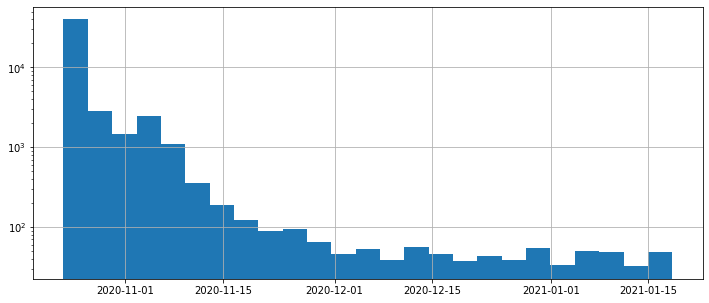

In [9]:
ax = df1['Updated At'].hist(bins=25, figsize=(12, 5))
ax.set_yscale('log')

In [10]:
import emoji
print(emoji.demojize('trending 😉	'))

trending :winking_face:	


In [11]:
df_corpus = df1

In [12]:
df_corpus.rename(columns={'Comments': 'comment_text'}, inplace=True)

In [13]:
# De-emojize
df_corpus['comments_cleaned'] = df_corpus['comment_text'].apply(emoji.demojize)

# Replace the colons, and \n with a space
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.replace('[\n:]', ' ', regex=True)
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.replace(r'\\n', ' ', regex=True)

In [14]:
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.lower()

In [15]:
df_corpus.drop_duplicates(subset=['comments_cleaned'], inplace = True)
df_corpus.shape

(47184, 7)

In [16]:
# remove special characters
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.replace('[^a-zA-Z0-9]', ' ')

# remove white spaces
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.replace('\s+', ' ', regex=True)
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.strip()

In [17]:
df_corpus['comments_cleaned'].to_csv('meta.tsv', columns=['comments_cleaned'], index= False, header= False)

The longest comment has 9649 characters

In [18]:
df_corpus['comments_cleaned'].apply(len).sort_values(ascending=False).head(20)

13649    9649
8742     9572
14669    9357
39329    8032
18645    7502
13222    7429
4739     7033
48888    6823
17436    6714
26363    6246
30068    6076
19148    5943
9159     5886
46668    5758
4851     5732
15616    5653
5239     5653
3757     5540
29311    5498
13054    5313
Name: comments_cleaned, dtype: int64

## Sentence Bert Embeddings

In [19]:
corpus_embeddings = embedder.encode(df_corpus["comments_cleaned"].values.tolist())

In [20]:
corpus_embeddings = np.array(corpus_embeddings)
corpus_embeddings.shape

(47184, 768)

In [21]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, corpus_embeddings, 90)

## Google Universal Encoder

In [22]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/5'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder-large/5, Total size: 577.10MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/5'.


module https://tfhub.dev/google/universal-sentence-encoder-large/5 loaded


In [23]:
#@title Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the emtbedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [-0.03458563610911369, -0.017990142107009888, 0.001980570377781987, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.05833395943045616, -0.08185011148452759, 0.06890935450792313, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the emtbedding will be.
Embedding size: 512
Embedding: [-0.018883388489484787, -0.0031109368428587914, -0.033673327416181564, ...]



## Semantic Textual Similarity Task Example

The embeddings produced by the Universal Sentence Encoder are approximately normalized. The semantic similarity of two sentences can be trivially computed as the inner product of the encodings.

In [24]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

In [25]:
messages0 = df_corpus["comments_cleaned"].values.tolist()

In [26]:
df_corpus["comments_cleaned"].apply(len).max()

9649

In [27]:
# embeddings_long = embed([df_corpus['comments_cleaned'].loc[617593]])

In [28]:
# [USComments.csv] Take only the first 2200 characters of each comment. Crashes at 2300+
# [Presidential Debate 1] < 2200. Trying 2000 [Nope]. Trying 1800 [Nope].
# Trying 1000 [Nope]. Trying 500 [Nope]. Trying 200.
max_chars = 200
messages = df_corpus["comments_cleaned"].apply(
    lambda x: x[:max_chars]
).values.tolist()

In [29]:
print('Embeddings can only be done with about 500 rows at a time')
n_chunks = len(messages) // 500
message_list = np.array_split(np.array(messages), n_chunks)
print(f'The {len(messages)} messages will be divided into {n_chunks} chunks of approximately 500 rows per chunk')

Embeddings can only be done with about 500 rows at a time
The 47184 messages will be divided into 94 chunks of approximately 500 rows per chunk


In [30]:
for i, message in enumerate(message_list):
    if i == 0:
        embeddings = embed(message).numpy()
    else:
        embedding = embed(message).numpy()
        embeddings = np.vstack((embeddings, embedding))

In [53]:
print(f'The embeddings numpy array has shape: {embeddings.shape}')

The embeddings numpy array has shape: (47184, 512)


Saving 47k rows of data will take a long time (the final size is 588MB)

In [32]:
np.savetxt('vecs0.tsv', embeddings , delimiter="\t")

In [54]:
# Check the final size of the file
!ls -lh vecs.tsv

-rw-r--r-- 1 root root 588M Mar 22 12:22 vecs.tsv


In [34]:
pd.Series(messages).apply(len).max()

200

### PCA reduction

The size of `vecs.tsv` can be reduced further.
Using PCA, the number of dimensions of each embedding is reduced from 512 to 50.

In [35]:
from sklearn.decomposition import PCA

In [36]:
#scale the data 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
rescaled = scaler.fit_transform(embeddings)

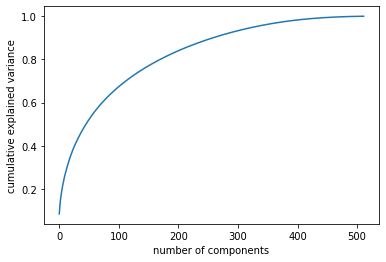

In [37]:
pca = PCA().fit(rescaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [38]:
# need around 200 components to describe 100% of variance
pca = PCA(n_components = 50)
reduced_embeds = pca.fit_transform(rescaled)
print("Original shape:   ", rescaled.shape)
print("Transformed shape:", reduced_embeds.shape)

Original shape:    (47184, 512)
Transformed shape: (47184, 50)


In [39]:
pca = PCA(n_components = 50)
reduced_embeds = pca.fit_transform(rescaled)
reduced_embeds.shape

(47184, 50)

In [55]:
np.savetxt('vecs.tsv', reduced_embeds , delimiter="\t")

After dimension reduction using PCA, the file size has been reduced from 588 MB to 58 MB.

In [56]:
!ls -lh vecs*.tsv

-rw-r--r-- 1 root root 58M Mar 22 12:42 vecs2.tsv
-rw-r--r-- 1 root root 58M Mar 22 12:46 vecs.tsv


## Run HDBScan to find the clusters

Note: the next code block takes a long time

In [40]:
import hdbscan

clusterer = hdbscan.HDBSCAN()
clusterer.fit(reduced_embeds)
clusterer.labels_

array([ -1,  -1,  -1, ...,  -1,  -1, 207])

In [41]:
clusterer.labels_.max()

334

In [42]:
df_corpus['hdb_labels'] = clusterer.labels_

In [43]:
df_corpus.to_csv('meta_lab.tsv', columns=['comments_cleaned','hdb_labels'], index= False, header= True, sep='\t')

In [44]:
!head -5 meta.tsv

25 28 trump did you hear anything biden no what was that sound
53 39 trump the idiot your the big man i dont know if you are but your the big man which is it trump grammer helps
trump is the president of the usa no biden
driving home from school today because that wednesday i m going to schools for the day so i m not going out of the house to get wills house
trump won election the swamp rats in washington did everything they could to cheat in order to have biden win congrats you now have the power and this country and all we can do is sit around and watch you waste our money change the constitution do whatever they want and clearly i don t see our country strong and proud this election was a disgrace 75 million people voted for president trump and the few swing states should be ashamed of themselves for being pushed around to be bullied into being dishonest no one on trump side believes for one second that sleepy joe won he is not my president i am sad angry frustrated and upset so pel

In [45]:
!head -5 meta_lab.tsv

comments_cleaned	hdb_labels
25 28 trump did you hear anything biden no what was that sound	-1
53 39 trump the idiot your the big man i dont know if you are but your the big man which is it trump grammer helps	-1
trump is the president of the usa no biden	-1
driving home from school today because that wednesday i m going to schools for the day so i m not going out of the house to get wills house	-1


In [47]:
!ls -lh *.tsv

-rw-r--r-- 1 root root 6.2M Mar 22 12:25 meta_lab.tsv
-rw-r--r-- 1 root root 6.0M Mar 22 12:15 meta.tsv
-rw-r--r-- 1 root root 588M Mar 22 12:22 vecs.tsv


Save`vecs.tsv` and `meta_lab.tsv` and load them into http://projector.tensorflow.org/ (use `vecs.tsv` for Step 1 and `meta_lab.tsv` for step 2). Downloading files from Google Colab can take a while. For faster downloading, `vecs.tsv` has been compressed as `vecs.tar.bz2` (file reduction from 58 MB to 20 MB).

In [60]:
!tar -cjf vecs.tar.bz2 vecs.tsv
!ls -lh vecs.tar.bz2

In [62]:
from google.colab import files

files.download('vecs.tar.bz2')
files.download('meta_lab.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>